In [1]:
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, balanced_accuracy_score

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectKBest

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df_vfc = pd.read_csv("vfc_dataset_janela-17_fs-80.csv")

### Tratando dados nulos

In [3]:
cols_drop = df_vfc[df_vfc.columns[df_vfc.isin([np.nan, np.inf, -np.inf]).any(0)]].columns

C:\Users\Ana\AppData\Local\Temp\ipykernel_14672\3876734435.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  cols_drop = df_vfc[df_vfc.columns[df_vfc.isin([np.nan, np.inf, -np.inf]).any(0)]].columns


In [4]:
print("Antes de remover os dados nulos e infitos: ", df_vfc.shape)

df_vfc_clean = df_vfc.drop(columns=cols_drop)

print("Depois de remover os dados nulos e infitos: ", df_vfc_clean.shape)

Antes de remover os dados nulos e infitos:  (4349, 24)
Depois de remover os dados nulos e infitos:  (4349, 18)


### Normalizando os dados

In [5]:
X = df_vfc_clean.drop(["labels"],axis=1)
Y = df_vfc_clean["labels"]

cols = X.columns.tolist()

scaler_features = StandardScaler()

df_scaled= scaler_features.fit_transform(X)
df_scaled = pd.DataFrame(df_scaled, columns=cols)   

df_scaled.reset_index(drop=True,inplace=True)

Y.reset_index(drop=True, inplace=True)

df_scaled["labels"] = Y.copy()

In [6]:
df_scaled.head()

,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,min_hr,lf,hf,total_power,vlf,labels
0,-2.786197,-0.870013,-0.791224,0.0,0.0,0.0,0.0,-0.788048,-2.800981,-0.807138,-0.612957,-0.664377,4.391060,-0.24394,-0.24394,-0.24394,-0.24394,1
1,-2.747960,-0.713994,-0.725992,0.0,0.0,0.0,0.0,-0.722719,-2.720314,-0.734624,-0.517160,-0.437290,4.187320,-0.24394,-0.24394,-0.24394,-0.24394,1
2,-2.712113,-0.827035,-0.696244,0.0,0.0,0.0,0.0,-0.693418,-2.679981,-0.734624,-0.476572,-0.606735,4.088506,-0.24394,-0.24394,-0.24394,-0.24394,1
3,-2.595012,-0.802306,-0.868687,0.0,0.0,0.0,0.0,-0.854370,-2.599314,-0.770881,-0.719782,-0.581140,3.896691,-0.24394,-0.24394,-0.24394,-0.24394,1
4,-2.716892,-0.368650,-0.628483,0.0,0.0,0.0,0.0,-0.621211,-2.841314,-0.517080,-0.368568,0.063234,3.622670,-0.24394,-0.24394,-0.24394,-0.24394,1


### Escolha das features

In [7]:
x_train, x_test, y_train, y_test = train_test_split(df_scaled.drop(columns=['labels']), df_scaled['labels'], random_state=42)

c:\Users\Ana\Documents\biomedica\informatica_medica\venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [3 4 5 6] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Ana\Documents\biomedica\informatica_medica\venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


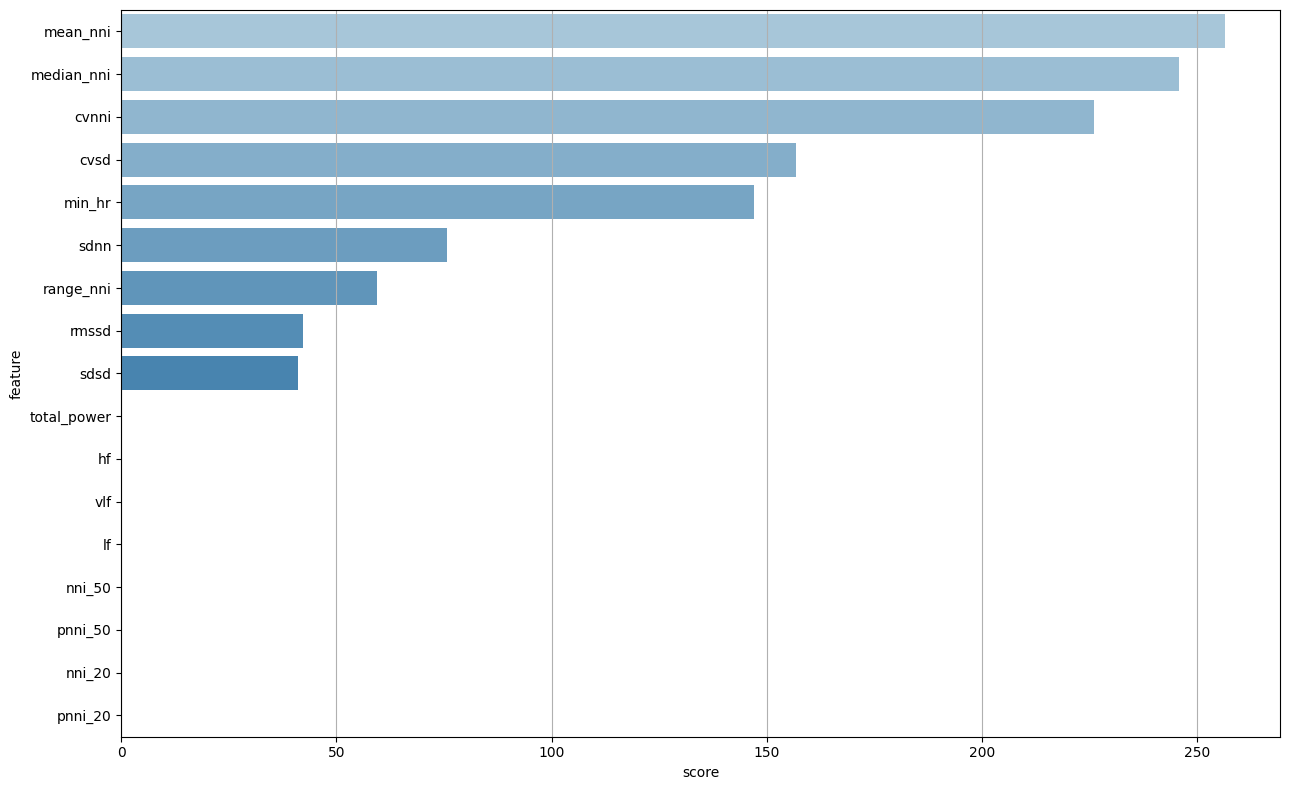

In [8]:
features_to_use = SelectKBest(k='all')

features_fit = features_to_use.fit(x_train, y_train)

df_scores = pd.DataFrame({'feature': x_train.columns.tolist(), 'score': list(features_fit.scores_)})
df_scores.sort_values(by='score', axis=0, ascending=False, inplace=True)

plt.figure(figsize=(13,8))
plt.grid(True)
sns.barplot(x=df_scores.score, y=df_scores.feature, palette='Blues_d')
plt.tight_layout()

### Random Forest Classifier

In [9]:
n_iter = 20

In [10]:
param_search = {'n_estimators': [400],
                  'oob_score': [False],
                  'criterion': ['gini'],
                  'bootstrap':[True],
                  'class_weight':['balanced_subsample'],
                  'min_weight_fraction_leaf':[0, 0.1, 0.2, 0.3, 0.4, 0.5], 
                  'min_impurity_decrease':[0, 0.1],
                  'min_samples_split': [10, 30, 60, 80],
                  'min_samples_leaf': [10, 30, 60, 80]
                 }
            
cv = RepeatedStratifiedKFold(n_splits=5, 
                    n_repeats=3, 
                    random_state=42)

rs_rf = RandomizedSearchCV(RandomForestClassifier(n_jobs=1),
                        param_distributions=param_search,
                        n_iter=n_iter,
                        scoring='f1',
                        random_state=42,
                        n_jobs=-1,
                        cv=cv)

rs_rf.fit(x_train, y_train)

model, best_score = rs_rf.best_estimator_, rs_rf.best_score_

y_pred_test_rf = model.predict(x_test)
y_pred_train_rf = model.predict(x_train)

In [11]:
print("Verificar overfitting do modelo")
print("Balanced Acc. Test: ", balanced_accuracy_score(y_test, y_pred_test_rf))
print("Balanced Acc. Train: ", balanced_accuracy_score(y_train, y_pred_train_rf))

Verificar overfitting do modelo
Balanced Acc. Test:  0.9084854186265288
Balanced Acc. Train:  0.9571926103760483


In [12]:
print(classification_report(y_test, y_pred_test_rf))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97      1063
           1       0.25      0.88      0.39        25

    accuracy                           0.94      1088
   macro avg       0.62      0.91      0.68      1088
weighted avg       0.98      0.94      0.95      1088



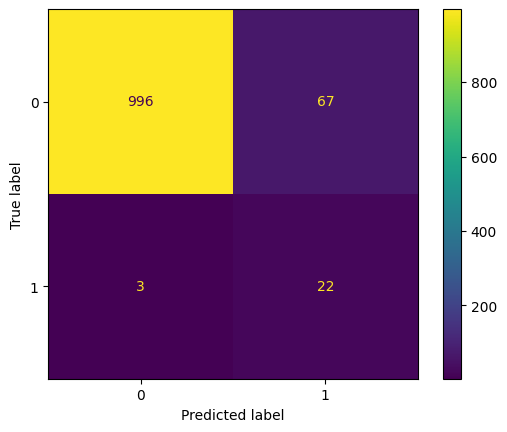

In [13]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_rf)

### LogisticRegression

In [14]:
lr = LogisticRegression(random_state=42)
lr.fit(x_train, y_train)
y_pred_lr = lr.predict(x_test)
y_pred_train_lr = lr.predict(x_train)

In [15]:
print("Verificar overfitting do modelo")
print("Balanced Acc. Test: ", balanced_accuracy_score(y_test, y_pred_lr))
print("Balanced Acc. Train: ", balanced_accuracy_score(y_train, y_pred_train_lr))

Verificar overfitting do modelo
Balanced Acc. Test:  0.6176481655691439
Balanced Acc. Train:  0.6023555502922906


In [16]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1063
           1       0.55      0.24      0.33        25

    accuracy                           0.98      1088
   macro avg       0.76      0.62      0.66      1088
weighted avg       0.97      0.98      0.97      1088



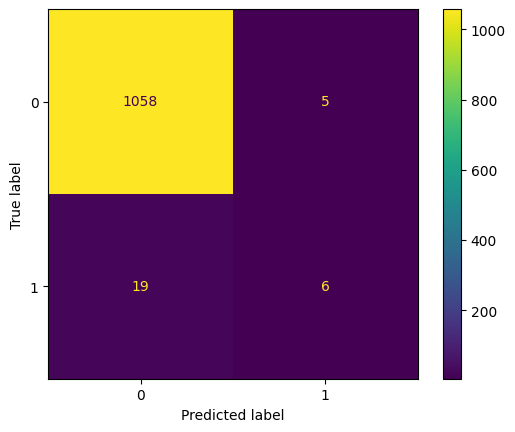

In [17]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr)

### KNeighborsClassifier

In [18]:
param_search = {'n_neighbors': np.arange(5, 100,5),
                'weights':['uniform', 'distance'],
                'algorithm':['auto']
                }
            
cv = RepeatedStratifiedKFold(n_splits=5, 
                    n_repeats=3, 
                    random_state=42)



rs_neigh = RandomizedSearchCV(KNeighborsClassifier(n_jobs=1),
                        param_distributions=param_search,
                        n_iter=n_iter,
                        scoring='f1',
                        random_state=42,
                        n_jobs=-1,
                        cv=cv)

rs_neigh.fit(x_train, y_train)

model, best_score = rs_neigh.best_estimator_, rs_neigh.best_score_

y_pred_test_neigh = model.predict(x_test)
y_pred_train_neigh = model.predict(x_train)

In [19]:
print("Verificar overfitting do modelo")
print("Balanced Acc. Test: ", balanced_accuracy_score(y_test, y_pred_test_neigh))
print("Balanced Acc. Train: ", balanced_accuracy_score(y_train, y_pred_train_neigh))

Verificar overfitting do modelo
Balanced Acc. Test:  0.537648165569144
Balanced Acc. Train:  0.6628564815313229


In [20]:
print(classification_report(y_test, y_pred_test_neigh))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1063
           1       0.29      0.08      0.12        25

    accuracy                           0.97      1088
   macro avg       0.63      0.54      0.56      1088
weighted avg       0.96      0.97      0.97      1088



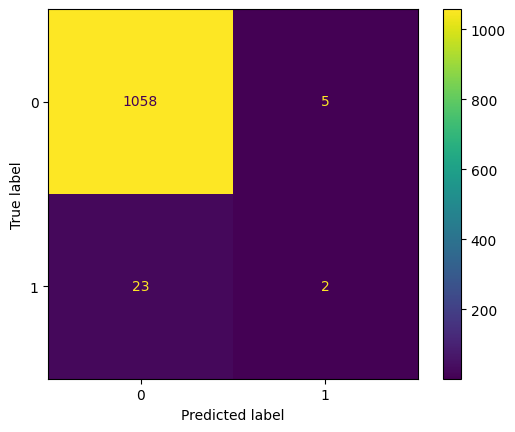

In [21]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_neigh)